# Medicare.Gov Data Exploration
#### Objectives:
1. Connect to Socrata Open Data API (SODA)
    - Post-Acute Facilties: 
        - https://data.medicare.gov/Nursing-Home-Compare/Provider-Info/4pq5-n9py
    - Penalties or fines: 
        - https://data.medicare.gov/Nursing-Home-Compare/Penalties/g6vv-u9sr
    - Long Term Care Minimum Data's quality Measures:
        - https://data.medicare.gov/Nursing-Home-Compare/MDS-Quality-Measures/djen-97ju
    - Center for Medicare and Medicaid Services Star Rating: 
        - https://data.medicare.gov/Nursing-Home-Compare/Star-Ratings/ax9d-vq6k
    
2. Run initial exploratory data analysis and ask the following questions:
    1. What are some frequency counts of interest?
    2. What are some trends that show high, low, increases, decreases, or outliers?
    3. What do histograms display?
    4. What are some quantities to compare?
    5. What scatter plots are interesting?
    6. What time of time series data trends are interesting?
3. What are some initial hypotheses or insights? What should I investigate next?
4. Data presentation
    - What are some ways to narrate this data?
    - What additional data do I need to make this story more complete?


## Setting up
- Load libraries
- set paths
- read data

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

%matplotlib inline

# Read Provider
info = 'https://data.medicare.gov/resource/b27b-2uc7.json?$select='
info_cols = pd.Series([
    'federal_provider_number','provider_name','provider_state','provider_city','ownership_type',
    'number_of_certified_beds','number_of_residents_in_certified_beds','overall_rating','total_weighted_health_survey_score',
    'number_of_substantiated_complaints', 'number_of_fines', 'total_amount_of_fines_in_dollars',
    'number_of_payment_denials', 'total_number_of_penalties']).str.cat(sep = ',')
info = pd.read_json(info+info_cols).set_index('federal_provider_number').sort_index()

# Read Penalty
fines = 'https://data.medicare.gov/resource/im9k-ugyp.json?$select='
fines_cols = pd.Series(['federal_provider_number','penalty_date','penalty_type','fine_amount']).str.cat(sep = ',')
# fines = pd.read_json(fines+fines_cols).set_index('federal_provider_number').sort_index()

# Read MDS
mds = 'https://data.medicare.gov/resource/adup-8cbx.json?$select='
mds_cols = pd.Series([
    'federal_provider_number',
    #'measure_code',
    #'measure_description','resident_type',
    'three_quarter_average']).str.cat(sep = ',')
mds = pd.read_json(mds + mds_cols).set_index('federal_provider_number').sort_index()

# Read Star
star = 'https://data.medicare.gov/resource/ax9d-vq6k.json?$select='
star_cols = pd.Series(['federal_provider_number','health_inspection_rating','qm_rating','staffing_rating','rn_staffing_rating']).str.cat(sep = ',')
star = pd.read_json(star+star_cols+'&$limit=50000').set_index('federal_provider_number').sort_index()


(15662, 4)

### A. Initial Transformations




In [8]:
# Compute rate of bed occupancy
info.occupancy_rate = info.number_of_residents_in_certified_beds/info.number_of_certified_beds

# join 3 star rating
info = info.merge(mds[['three_quarter_average']], left_index= True, right_index=True)

### B. Create Cross Tabs

#### Info Crosstab

In [13]:
owner_rating = pd.crosstab(
    info.overall_rating,
    info.provider_state) # "index" for rows, 'columns' for columns
owner_rating

provider_state,AZ,CA,CT,FL,GA,HI,IA,IL,IN,KY,...,NY,OH,OK,PA,TN,TX,VA,WA,WI,WY
overall_rating,,,,,,,,,,,,,,,,,,,,,
1.0,0,2,0,0,1,0,0,1,2,0,...,1,0,0,0,0,4,1,0,1,0
2.0,0,0,1,2,0,1,0,1,0,1,...,0,0,0,1,1,1,0,1,0,0
3.0,0,0,0,0,0,0,0,2,0,0,...,3,0,0,1,0,1,1,0,0,0
4.0,1,0,0,0,0,0,1,2,0,1,...,0,0,1,0,3,1,0,0,0,0
5.0,0,2,0,0,0,0,0,1,0,0,...,1,2,0,0,1,0,0,0,0,1


### C. Scatter Matrices
#### Setting up the data

In [22]:
to_scatter_matrix = info.select_dtypes(exclude=['object'])
to_scatter_matrix = to_scatter_matrix[[0,3,5,6,8]]

#### Info Scatter Matrix

C:\Users\chris\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


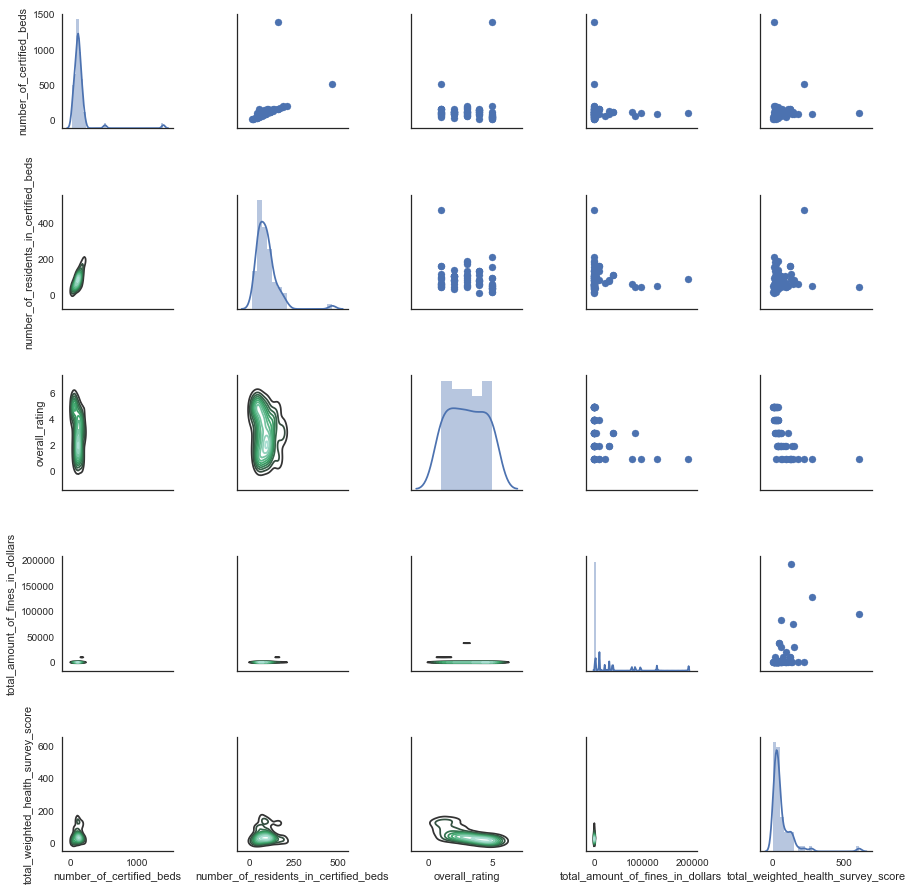

In [28]:
# http://seaborn.pydata.org/examples/pair_grid_with_kde.html
plt.pylab.rcParams['figure.figsize'] = (16, 16)

sns.set(style="white")

df = to_scatter_matrix

g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot,)
g.map_upper(plt.pyplot.scatter)
g.map_diag(sns.distplot)


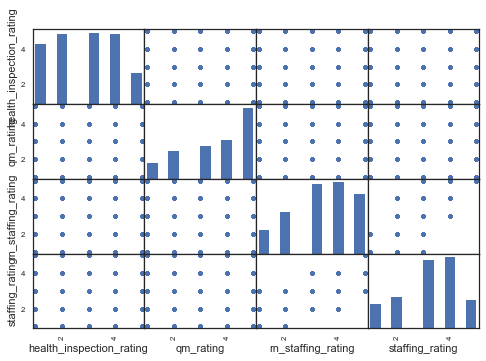

In [27]:
_ = pd.tools.plotting.scatter_matrix(star)

In [147]:
star_melt = pd.melt(frame=star,value_vars=['health_inspection_rating', 'qm_rating', 'rn_staffing_rating',
       'staffing_rating'])


star_melt['count'] = 1
star_melt = star_melt.pivot_table(columns='variable', index= 'value', aggfunc= np.sum)
star_melt.columns = star_melt.columns.droplevel(0)
star_melt = star_melt.reset_index()

star_melt.columns.rename({'value':'x'})


star_melt
# https://stackoverflow.com/questions/38152686/iterating-over-columns-with-for-loops-in-pandas-dataframe


variable,value,health_inspection_rating,qm_rating,rn_staffing_rating,staffing_rating
0,1.0,3078,1284,1342,1680
1,2.0,3587,2302,2384,2107
2,3.0,3668,2771,4000,4642
3,4.0,3589,3203,4072,4834
4,5.0,1605,5940,3408,1943


In [103]:
sns.factorplot(x = star_melt.value, y = star_melt.health_inspection_rating)


TypeError: object of type 'NoneType' has no len()

In [ ]:
mds  +',MAX(three_quarter_average)&$group=measure_code'

In [ ]:
'https://soda.demo.socrata.com/resource/4tka-6guv.json?$select=region,MAX(magnitude)&$group=region'

In [ ]:

mds = 'https://data.medicare.gov/resource/adup-8cbx.json?$select='
mds_cols = pd.Series([
    'federal_provider_number']).str.cat(sep = ',')
mds = pd.read_json(mds + mds_cols +',max(tree_quarter_average)&$group=measure_code'+ '&$limit=100')
mds

In [ ]:

# http://pbpython.com/pandas-pivot-table-explained.html
table_bed_capacity = info.pivot_table(
    index = ['provider_state'],
    columns = ['provider_city'],
    values = ['number_of_residents_in_certified_beds', 'number_of_certified_beds','three_quarter_average'],    
     aggfunc={
         'number_of_residents_in_certified_beds':np.sum,
          'number_of_certified_beds':np.sum,
         'three_quarter_average':np.mean       
     },
    fill_value=0,
    margins = True)

table_bed_capacity = table_bed_capacity.stack('provider_city')
table_bed_capacity = table_bed_capacity.query('number_of_residents_in_certified_beds != 0')
table_bed_capacity['rate'] = table_bed_capacity.number_of_residents_in_certified_beds/table_bed_capacity.number_of_certified_beds
table_bed_capacity_wo_all = table_bed_capacity.query("provider_city != ['All'] & provider_state != ['All']")
table_bed_capacity_wo_all.sort_values('rate', ascending = 0)
mean_rate = sum(table_bed_capacity_wo_all.number_of_residents_in_certified_beds)/sum(table_bed_capacity_wo_all.number_of_certified_beds)
table_bed_capacity_wo_all['low_high'] = np.where(table_bed_capacity_wo_all.rate >= mean_rate, '1','0')
# http://matplotlib.org/1.4.3/examples/color/colormaps_reference.html
# https://stackoverflow.com/questions/30353363/seaborn-regplot-with-colorbar
# https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger

fig=plt.pyplot.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

points = plt.pyplot.scatter(
    table_bed_capacity_wo_all['number_of_certified_beds'],
    table_bed_capacity_wo_all['number_of_residents_in_certified_beds'],
    c = table_bed_capacity_wo_all['three_quarter_average'],
    alpha = .7,
    s = 75,
    cmap = 'RdGy')

plt.pyplot.colorbar(points)

x=np.linspace(0,600,601) 
plt.pyplot.plot(x,x,'k-')

In [ ]:
from bokeh.io import output_notebook, push_notebook, show
import bokeh as bk
output_notebook()


hover = bk.models.HoverTool(
 tooltips = [
     ("# of Certified Beds", "@x"),
    ("# of Residents", "@y"),
    ("Overall Rating", '@radius'),]
)

source = bk.models.ColumnDataSource(table_bed_capacity_wo_all[
    ['number_of_certified_beds',
     'number_of_residents_in_certified_beds', 
     'three_quarter_average']])


plot = bk.plotting.figure(tools = [hover])

plot.circle(
    x = 'number_of_certified_beds',
    y = 'number_of_residents_in_certified_beds',
    radius = 'three_quarter_average',
    alpha = .5,
    source = source)


t = show(plot, notebook_handle = True)

push_notebook(handle = t)
